In [5]:
import xarray as xr
from xeofs.single import EOF
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# client = Client()
# print(client.dashboard_link)

path = "/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc"

# Load dataset and select variable
ds = xr.open_dataset(path)#, chunks={'time': 10, 'xc': 100, 'yc': 100})
data = ds['temperature'].isel(zc=0)  # Replace with your variable of interest
data = data.drop_vars('zc')
data = data.assign_coords(time=('time', range(data.sizes['time'])))


# # Flatten the MultiIndex and reset coordinates
# data = data.stack(feature=('yc', 'xc')).reset_index('feature')
# data['feature'] = np.arange(data.sizes['feature'])  # Simplify 'feature' index
# data = data.drop_vars(['yc', 'xc'])  # Drop extra variables


# Perform Kernel EOF analysis with specified parameters
model = EOF(
    n_modes=10,               # Number of modes to calculate
    center=True,             # Center the input data
    standardize=True,       # Do not standardize the data
    use_coslat=False,         # Apply cosine latitude weighting
    solver='auto',           # Use the default solver
)

# Fit the model
model.fit(data, dim=['time'])

# Extract results
keofs = model.components()               # EOFs capture spatiotemporal patterns
pcs = model.scores()                     # Principal component time series
variance = model.explained_variance_ratio()  # Variance explained by each mode

# Save results
# keofs.to_netcdf("keofs.nc")
# pcs.to_netcdf("pcs.nc")
print("Explained variance per mode:", variance.values)

/cluster/home/haroldh/.conda/envs/eof/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Explained variance per mode: [0.9331938  0.01524911 0.01095024 0.00530965 0.00333434 0.00253432
 0.00225472 0.00176563 0.00134175 0.0012056 ]


In [4]:
data

<xarray.DataArray 'temperature' (time: 365, yc: 555, xc: 950)> Size: 770MB
array([[[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [7.722527, 7.727287, ..., 7.680471, 7.671743],
        [7.722527, 7.722527, ..., 7.671743, 7.671743]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [7.63921 , 7.637623, ..., 7.683645, 7.686026],
        [7.63921 , 7.629688, ..., 7.678091, 7.686026]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [8.051027, 8.051821, ..., 8.455703, 8.454909],
        [8.051027, 8.052614, ..., 8.455703, 8.454909]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [8.034364, 8.034364, ..., 8.471572, 8.470778],
        [8.034364, 8.034364, ..., 8.472365, 8.470778]]], dtype=float32)
Coordinates:
  * xc       (xc) float32 4kB 800.0 1.6e+03 2.4e+03 ... 7.592e+05 7.6e+05
  * yc       (yc) float32 2kB 800.0 1.6e+03 2.4e+03 ... 4.432e+05 4.44e+05
  * time     (time) int64 3kB 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
Attributes:
    units:            degC
    _CoordinateAxes:  time zc yc xc
    grid_mapping:     grid_mapping
    cell_methods:     time: mean

KeyError: "not all values found in index 'mode'. Try setting the `method` keyword argument (example: method='nearest')."

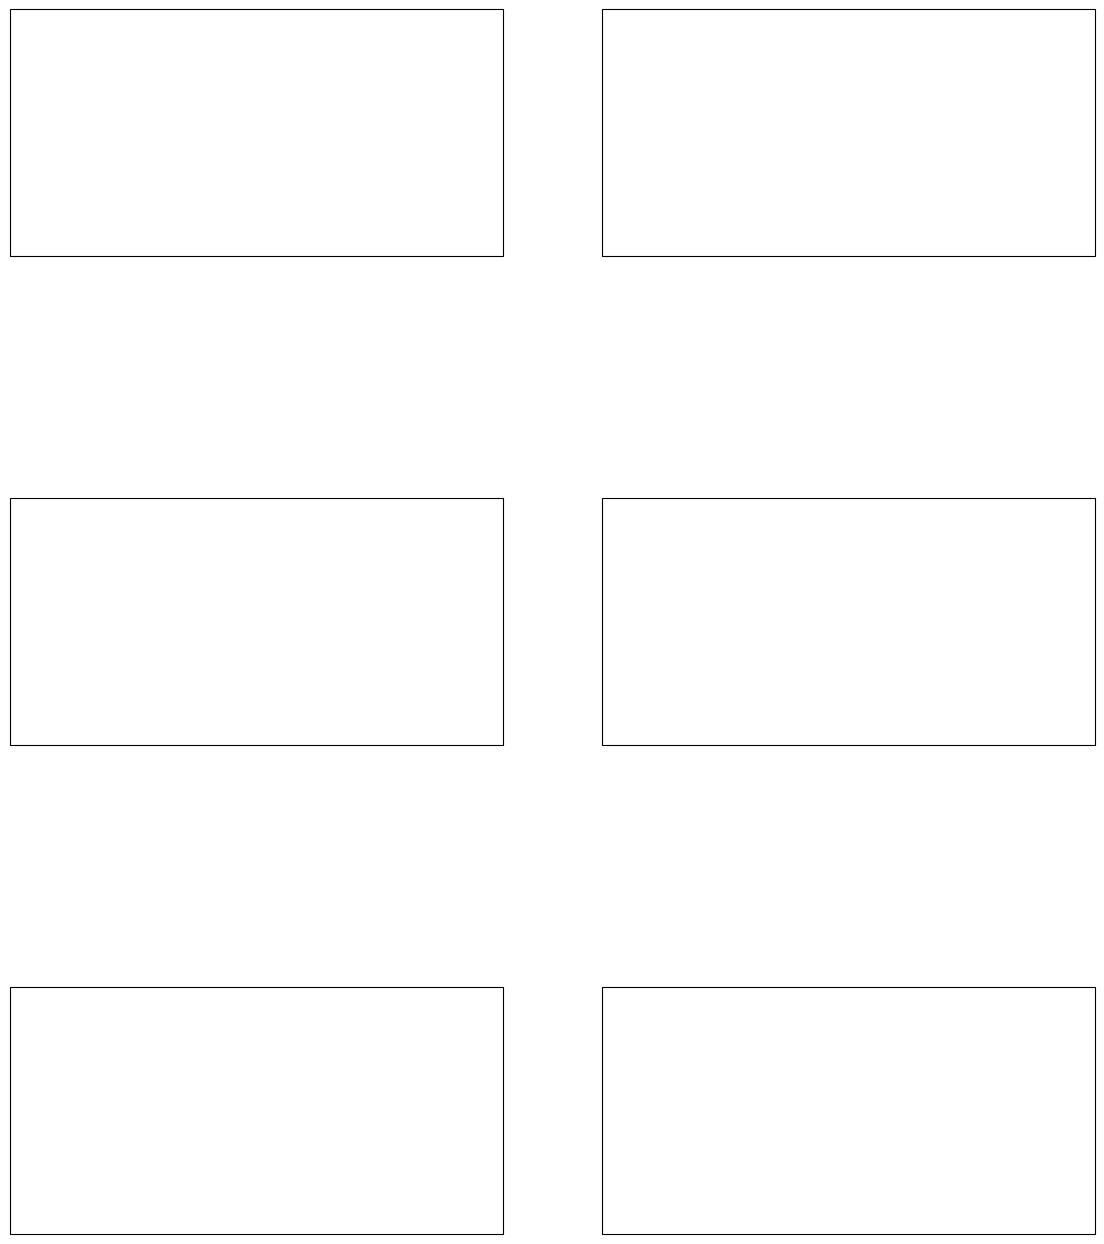

In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plotting the EOFs
def plot_eofs(keofs, variance):
    fig, axs = plt.subplots(3, 2, figsize=(14, 18), subplot_kw={'projection': ccrs.PlateCarree()})
    axs = axs.flatten()

    for i, ax in enumerate(axs[:-1]):  # Plot top 5 EOFs
        eof = keofs.sel(mode=i)
        eof.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': 'EOF Amplitude'})
        ax.set_title(f'EOF {i+1} (Explains {variance[i].values * 100:.2f}% Variance)')
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, color='lightgrey')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plotting the PCs
def plot_pcs(pcs):
    fig, ax = plt.subplots(figsize=(10, 6))
    for i in range(5):  # Plot first 5 PCs
        pcs.sel(mode=i).plot(ax=ax, label=f'PC {i+1}')
    
    ax.set_title('Principal Component Time Series')
    ax.set_xlabel('Time')
    ax.set_ylabel('PC Amplitude')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Call plotting functions
plot_eofs(keofs, variance)
plot_pcs(pcs)
